# 1 Arima predictions

In [16]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams

def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='cornflowerblue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    orig_p = plt.plot(timeseries, 'ok', markersize=2)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [17]:
data_file = "AirPassengers.csv"

df = pd.read_csv(data_file)
#Parse strings to datetime type
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True) #convert from string to datetime
indexeddf = df.set_index(['Month'])
display(indexeddf.tail(5))

print(indexeddf.dtypes)
print("shape: " + str(indexeddf.shape))

,#Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


#Passengers    int64
dtype: object
shape: (144, 1)


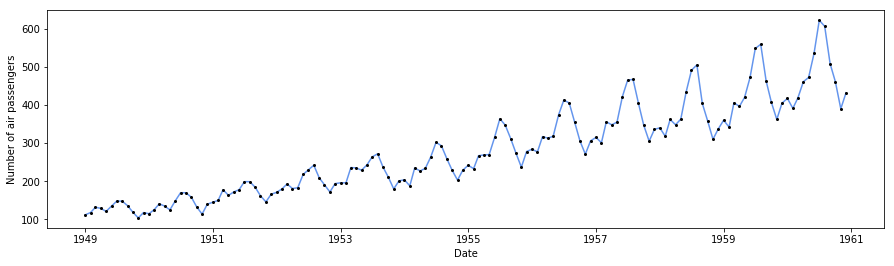

In [18]:
plt.figure(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(indexeddf, linestyle='-', color='cornflowerblue')
plt.plot(indexeddf, 'ok', markersize=2)

In [19]:
# size = 12 (months) = yearly
rol_mean = indexeddf.rolling(window=12).mean()
rol_std = indexeddf.rolling(window=12).std()

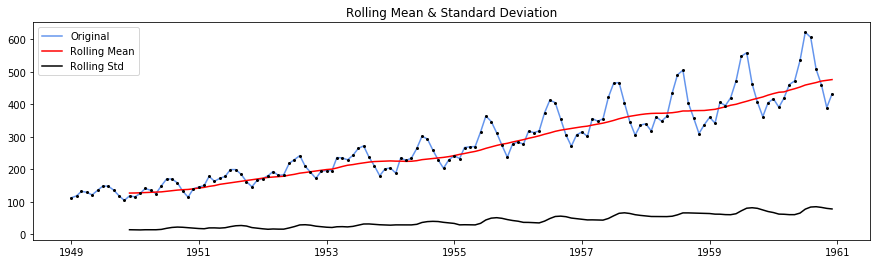

In [20]:
plt.figure(figsize=(15,4))
orig = plt.plot(indexeddf, color='cornflowerblue', label='Original')
mean = plt.plot(rol_mean, color='red', label='Rolling Mean')
std = plt.plot(rol_std, color='black', label='Rolling Std')
orig_p = plt.plot(indexeddf, 'ok', markersize=2)
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

&rarr; Time series is not stationary since rolling mean isn't parallel to x-axis. <br />
Confirmation:

In [21]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexeddf['#Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  0.815
p-value                         0.992
#Lags Used                     13.000
Number of Observations Used   130.000
Critical Value (10%)           -2.579
Critical Value (1%)            -3.482
Critical Value (5%)            -2.884
dtype: float64


&rarr; p-value near max (=1.0), so definitely not stationary.

## 1.1 Data transformation to stationary

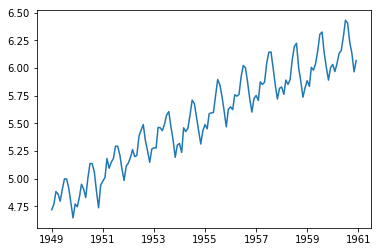

In [22]:
#Estimating trend
indexeddf_logScale = np.log(indexeddf)
plt.plot(indexeddf_logScale)

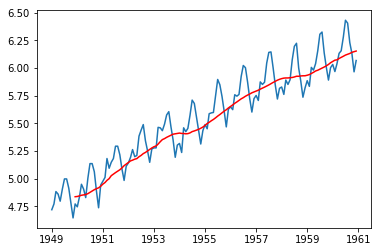

In [23]:
#The below transformation is required to make series stationary
movingAverage = indexeddf_logScale.rolling(window=12).mean()
movingSTD = indexeddf_logScale.rolling(window=12).std()
plt.plot(indexeddf_logScale)
plt.plot(movingAverage, color='red')

Subtracting two related series having similar trend components should make the result stationary.

In [24]:
datasetLogScaleMinusMovingAverage = indexeddf_logScale - movingAverage
display(datasetLogScaleMinusMovingAverage.head(12))

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
display(datasetLogScaleMinusMovingAverage.head(10))

,#Passengers
Month,
1949-01-01,nan
1949-02-01,nan
1949-03-01,nan
1949-04-01,nan
1949-05-01,nan
1949-06-01,nan
1949-07-01,nan
1949-08-01,nan
1949-09-01,nan


,#Passengers
Month,
1949-12-01,-0.065
1950-01-01,-0.093
1950-02-01,-0.008
1950-03-01,0.099
1950-04-01,0.052
1950-05-01,-0.028
1950-06-01,0.140
1950-07-01,0.260
1950-08-01,0.249


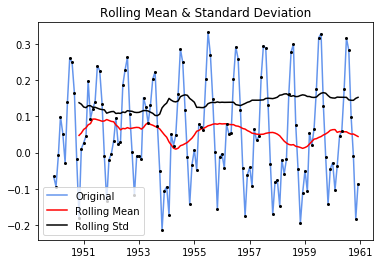

Results of Dickey Fuller Test:
Test Statistic                 -3.163
p-value                         0.022
#Lags Used                     13.000
Number of Observations Used   119.000
Critical Value (10%)           -2.580
Critical Value (1%)            -3.487
Critical Value (5%)            -2.886
dtype: float64


In [25]:
test_stationarity(datasetLogScaleMinusMovingAverage)

&rarr; p-value is now low enough for the time series to be considered stationary. We could also try out Exponential Decay Transformation and Time Shift Transformation, but log transformation will suffice for now. Another benefit of the log transformation is that we can easily revert the values to the original scale when making forecasts.

## 1.2 Break down components of log scale series

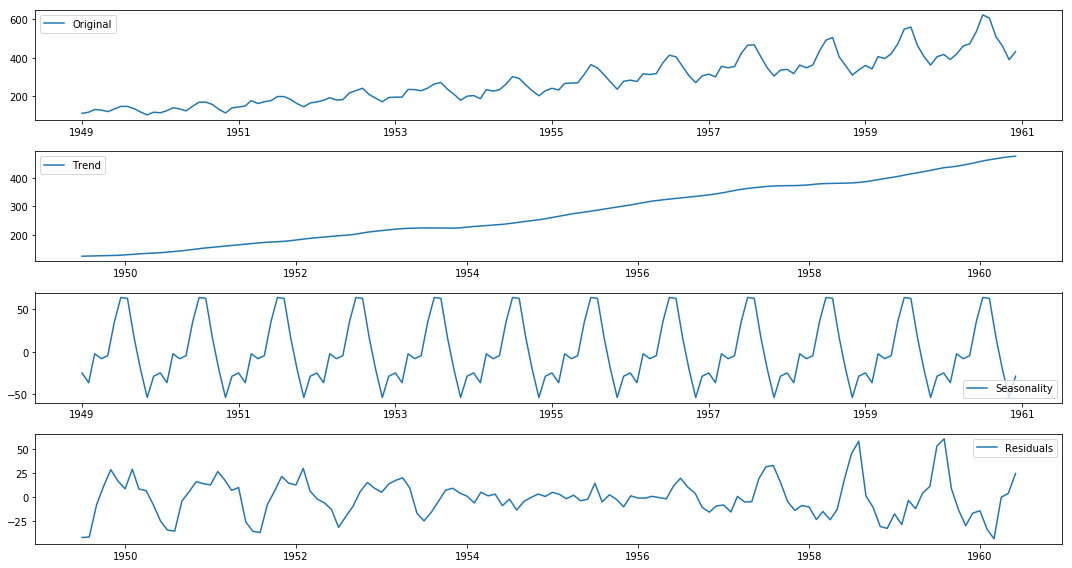

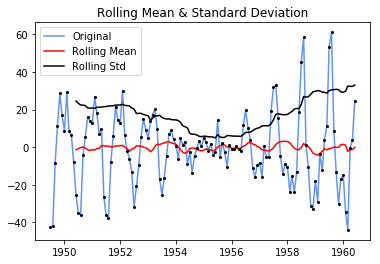

Results of Dickey Fuller Test:
Test Statistic                 -5.298
p-value                         0.000
#Lags Used                     13.000
Number of Observations Used   118.000
Critical Value (10%)           -2.580
Critical Value (1%)            -3.487
Critical Value (5%)            -2.886
dtype: float64


In [26]:
decomposition = seasonal_decompose(indexeddf) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))

ax1.plot(indexeddf, label='Original')
ax1.legend(loc='best')

ax2.plot(trend, label='Trend')
ax2.legend(loc='best')

ax3.plot(seasonal, label='Seasonality')
ax3.legend(loc='best')

ax4.plot(residual, label='Residuals')
ax4.legend(loc='best')

plt.tight_layout()
plt.show()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)


test_stationarity(decomposedLogData)

Time shift transformation

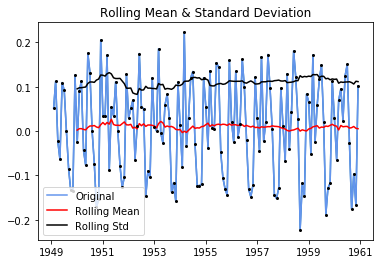

Results of Dickey Fuller Test:
Test Statistic                 -2.717
p-value                         0.071
#Lags Used                     14.000
Number of Observations Used   128.000
Critical Value (5%)            -2.884
Critical Value (10%)           -2.579
Critical Value (1%)            -3.483
dtype: float64


In [33]:
datasetLogDiffShifting = indexeddf_logScale - indexeddf_logScale.shift()
plt.plot(datasetLogDiffShifting)
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

&rarr; Rolling mean and Rolling std are relatively parallel to x-axis, and p-value is also low enough for the scaled time series to be considered stationary.

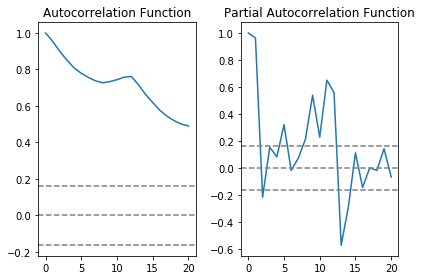

In [42]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(1,2,1)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(1,2,2)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

Plotting ARIMA model


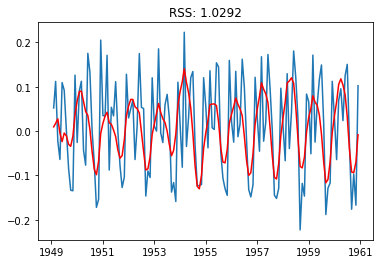

In [39]:
# order: (p,d,q)
# p is the order (number of time lags) of the autoregressive model
# d is the degree of differencing (the number of times the data have had past values subtracted)
# q is the order of the moving-average model
# RSS = Residual Sum of Squares error

model = ARIMA(indexeddf_logScale, order=(2,1,2), freq=indexeddf_logScale.index.inferred_freq)
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting ARIMA model')

In [40]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(indexeddf_logScale['#Passengers'].iloc[0], index=indexeddf_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
display(predictions_ARIMA_log.head())

Month
1949-01-01   4.718
1949-02-01   4.728
1949-03-01   4.746
1949-04-01   4.773
1949-05-01   4.769
dtype: float64

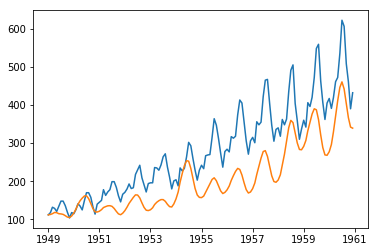

In [41]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexeddf)
plt.plot(predictions_ARIMA)

&rarr; This prediction captures some properties but doesn't scale well to the original time series.

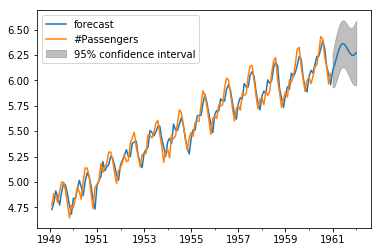

In [32]:
results_ARIMA.plot_predict(start=1,end=144+12) # predict an additional 12 months
fc = results_ARIMA.forecast(steps=120)
plt.show()

&rarr; The interpolation is good, and the prediction of an additional 12 months is decent using ARIMA on the log scaled time series.

# 2 SARIMAX predictions

SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with eXogenous regressors)<br />

The form is SARIMAX(p, d, q) x (P, D, Q)m, where p is the AR term, d is the I term, and q is the MA term. The capital P, D, and Q are the same terms but related to the seasonal component. The lowercase m is the number of seasonal periods before the pattern repeats (so, if you’re working with monthly data, like in this tutorial, m will be 12). <br />

The error we seek to minimize is the Akaike information criterion (AIC). The AIC is a measure of how well the model fits the data.<br />

ref.: https://towardsdatascience.com/forecasting-with-python-and-tableau-dd37a218a1e5

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
import matplotlib.pyplot as plt
from patsy import dmatrices
import statsmodels.api as sm

import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

import sys
import warnings
import itertools

In [3]:
data_file = "AirPassengers.csv"

df = pd.read_csv(data_file)
#Parse strings to datetime type
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True) #convert from string to datetime
df = df.set_index(['Month'])
display(df.head(5))

print(df.dtypes)
print("shape: " + str(df.shape))

y = pd.Series(data=df['#Passengers'].values, index=df.index)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


#Passengers    int64
dtype: object
shape: (144, 1)


In [4]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [5]:
from tqdm import tqdm_notebook
warnings.filterwarnings("ignore")

best_result = [0, 0, 10000000]
for param in tqdm_notebook(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
#             print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))

            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
            
print('\nBest Result:', best_result)



Best Result: [(2, 1, 2), (0, 2, 2, 12), 715.1568517356458]


In [6]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(best_result[0][0], best_result[0][1], best_result[0][1]),
                                seasonal_order=(best_result[1][0], best_result[1][1], best_result[1][2], best_result[1][3]),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1856      0.195     -6.092      0.000      -1.567      -0.804
ar.L2         -0.4353      0.099     -4.411      0.000      -0.629      -0.242
ma.L1          0.7787      0.204      3.812      0.000       0.378       1.179
ma.S.L12      -1.4145      0.227     -6.239      0.000      -1.859      -0.970
ma.S.L24       0.4839      0.143      3.381      0.001       0.203       0.764
sigma2       118.5127     28.038      4.227      0.000      63.558     173.467


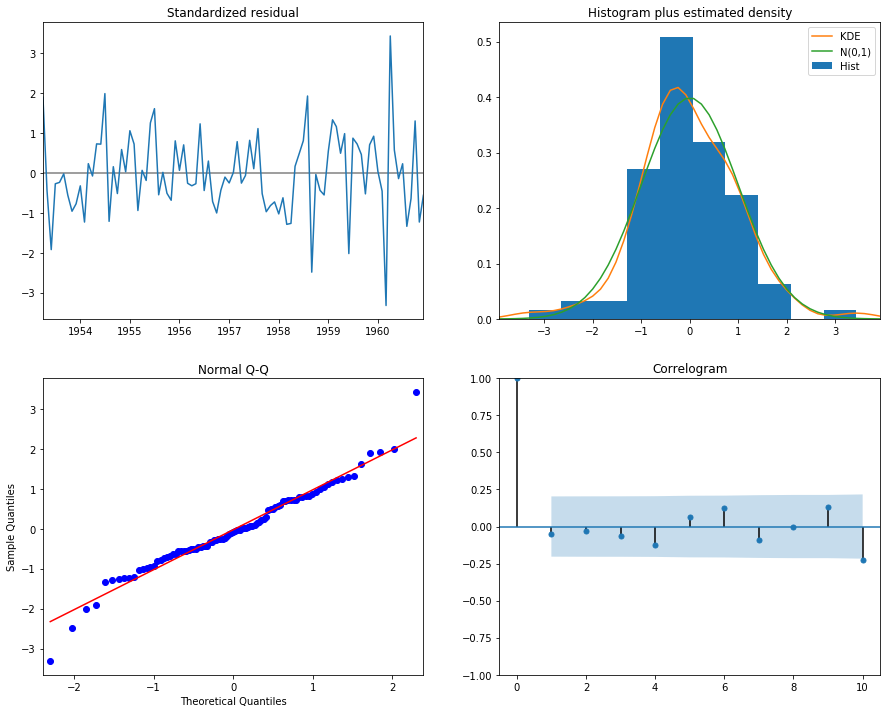

In [7]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [8]:
# Get forecast 12 steps (1 year) ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

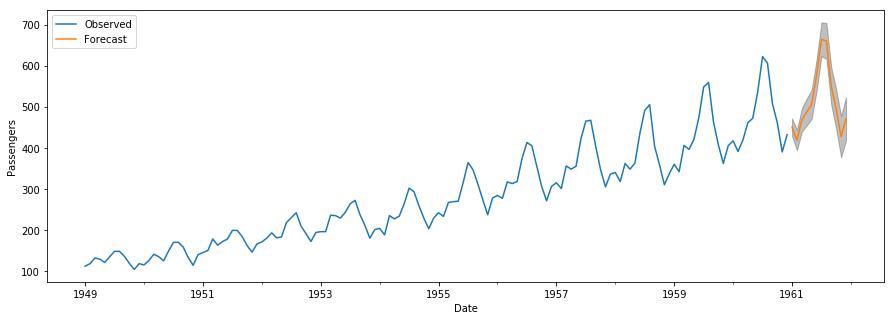

In [14]:
ax = y.plot(label='Observed', figsize=(15, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')

plt.legend()
plt.show()